<a href="https://colab.research.google.com/github/shubhamraj2604/AgriAid/blob/main/multiclass_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving crop_yield_weather.csv to crop_yield_weather.csv


In [2]:
import pandas as pd
df = pd.read_csv("crop_yield_weather.csv")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:55:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [16:55:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


Classification Report:

              precision    recall  f1-score   support

       Maize       0.33      0.33      0.33     33365
        Rice       0.34      0.33      0.33     33358
       Wheat       0.33      0.33      0.33     33335

    accuracy                           0.33    100058
   macro avg       0.33      0.33      0.33    100058
weighted avg       0.33      0.33      0.33    100058



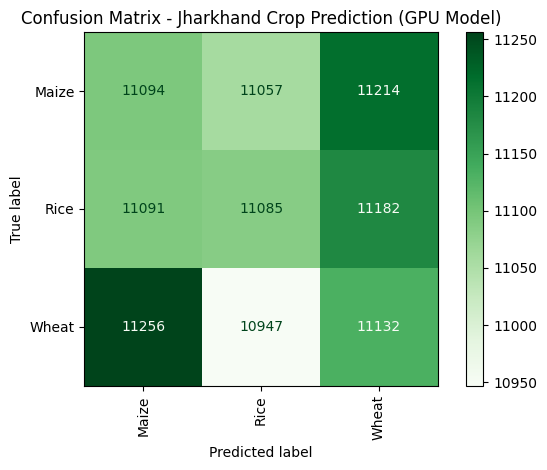

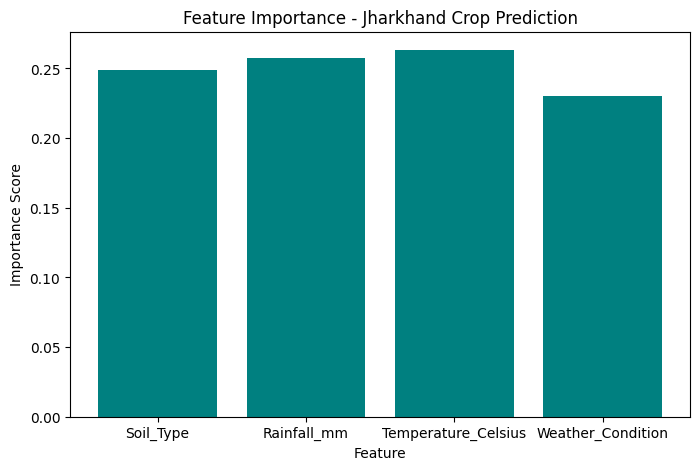

In [14]:
jharkhand_crops = [
    "Rice", "Wheat", "Maize", "Arhar", "Urad", "Moong", "Gram",
    "Mustard", "Niger", "Til", "Sesame", "Groundnut"
]

filtered_df = df[df['Crop'].isin(jharkhand_crops)]
selected_columns = [
    'Soil_Type', 'Rainfall_mm', 'Temperature_Celsius', 'Weather_Condition', 'Crop'
]
model_df = filtered_df[selected_columns].copy()

# Encoding catagorical data
from sklearn.preprocessing import LabelEncoder

soil_encoder = LabelEncoder()
weather_encoder = LabelEncoder()
crop_encoder = LabelEncoder()

model_df['Soil_Type'] = soil_encoder.fit_transform(model_df['Soil_Type'])
model_df['Weather_Condition'] = weather_encoder.fit_transform(model_df['Weather_Condition'])
model_df['Crop'] = crop_encoder.fit_transform(model_df['Crop'])

# Splitting the dataset
from sklearn.model_selection import train_test_split
X = model_df.drop('Crop', axis=1)
y = model_df['Crop']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = XGBClassifier(
    tree_method='gpu_hist',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=crop_encoder.classes_))

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=crop_encoder.classes_, cmap='Greens', xticks_rotation=90)
plt.title("Confusion Matrix - Jharkhand Crop Prediction (GPU Model)")
plt.tight_layout()
plt.savefig("Cmatrix_multiclass_model1.png", dpi=300)
plt.show()

# Feature Importance
plt.figure(figsize=(8,5))
plt.bar(X.columns, model.feature_importances_, color='teal')
plt.title("Feature Importance - Jharkhand Crop Prediction")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.savefig("feature_imp.png", dpi=300)
plt.show()


In [8]:
decoded_actual = crop_encoder.inverse_transform(y_test[:10])
decoded_pred = crop_encoder.inverse_transform(y_pred[:10])

for i in range(10):
    print(f"Actual: {decoded_actual[i]:<12} | Predicted: {decoded_pred[i]}")


Actual: Maize        | Predicted: Rice
Actual: Wheat        | Predicted: Rice
Actual: Wheat        | Predicted: Maize
Actual: Wheat        | Predicted: Wheat
Actual: Rice         | Predicted: Wheat
Actual: Wheat        | Predicted: Wheat
Actual: Wheat        | Predicted: Rice
Actual: Maize        | Predicted: Rice
Actual: Maize        | Predicted: Maize
Actual: Maize        | Predicted: Rice


In [9]:
print(filtered_df['Crop'].value_counts())

Crop
Maize    166824
Rice     166792
Wheat    166673
Name: count, dtype: int64


In [10]:
from sklearn.metrics import accuracy_score
print("Model Accuracy:", accuracy_score(y_test, y_pred))

Model Accuracy: 0.33291690819324793
